In [2]:
!pip install pydslog

You are using pip version 9.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


<IPython.core.display.Javascript object>


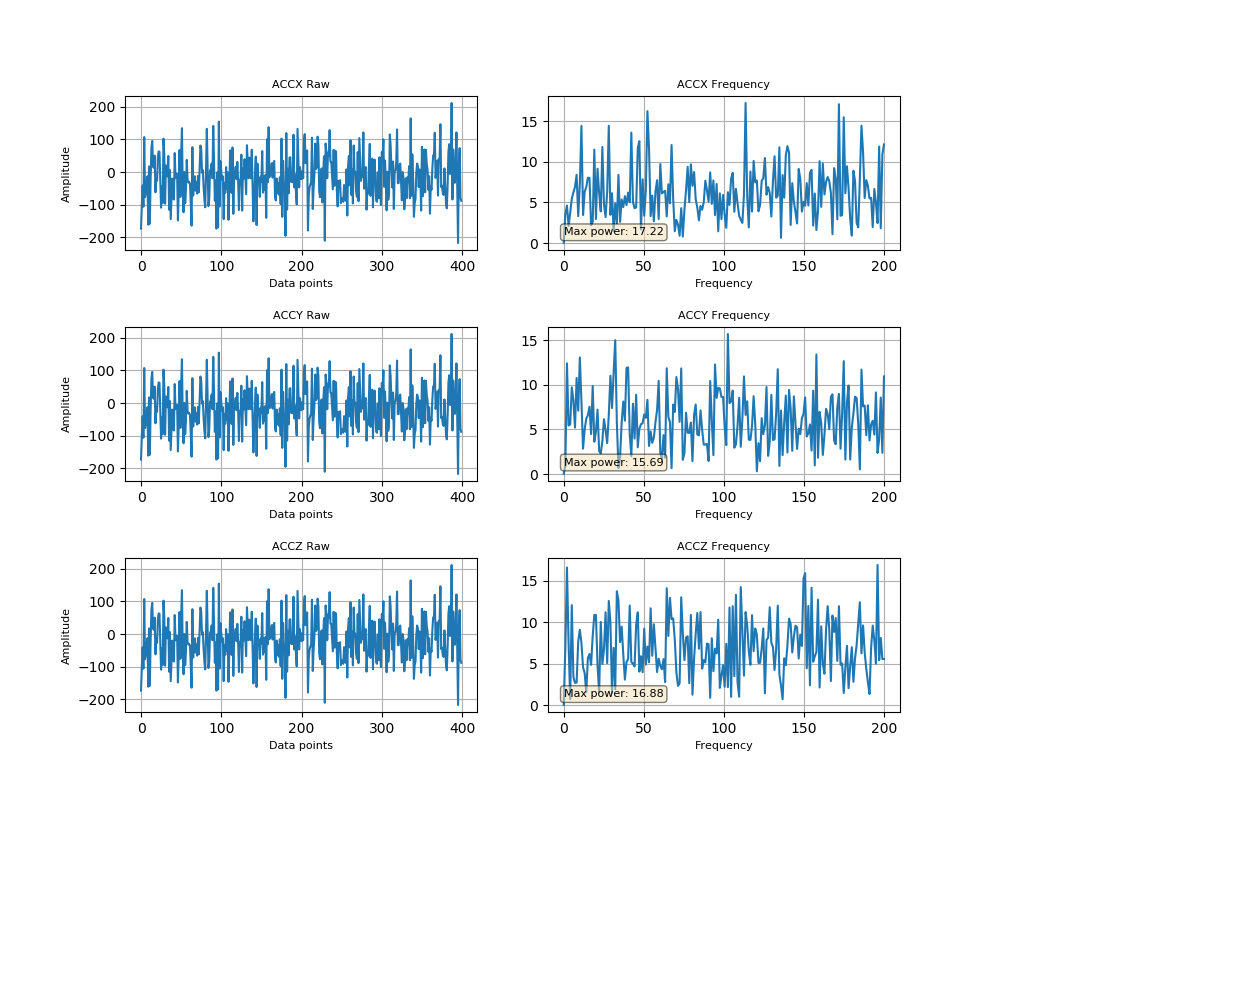

start stream


SerialException: WriteFile failed (PermissionError(13, 'Zugriff verweigert', None, 5))

In [2]:
%matplotlib notebook
import PyDSlog.stream as stream
import PyDSlog.transform as fft
import matplotlib.pyplot as plt
import numpy as np


### Modify here ### 

# Channels
chan = ["ACCX","ACCY","ACCZ"]
# Frequency
frequency = 400
# Signal length
size_signal = 400
# Port
serial_port = "COM10"

###


period = 1.0/frequency
peaks = 1


x = stream.MLS160A_stream(sz_block=size_signal, channels_to_use=chan,
                                      frequency=frequency, port=serial_port, baudrate=115200, n_frame=100)

transform = fft.FFTGenerator(period, size_signal, frequency)


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
        if mph is not None:
            mph = -mph
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    return ind


txt = []
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(nrows=len(chan), ncols=2, figsize=(10, 8))


print("start stream")

x.connect()
x.start()

try:
    
    #for i in range(10):
    
    while 1:

        sensor_values = x.read(transpose=False)
        sensor_values = np.array(sensor_values)

        fft_values = transform.doFFT(sensor_values, delete_offset=True)        

        for c in range(sensor_values.shape[0]):
            
            indices_peaks = detect_peaks(fft_values[0,c,:,1]) 

            ind = np.argpartition(fft_values[0,c,:,1], -peaks)[-peaks:]
            trigger = np.amin(fft_values[0,c,ind,1])
            trigger = np.round(trigger, 2)

            if ax[c][0].lines:

                ax[c][0].lines[0].set_ydata(sensor_values[0,:])
                ax[c][1].lines[0].set_ydata(fft_values[0,c,:,1])
                ax[c][1].lines[0].set_xdata(fft_values[0,c,:,0])
                txt[c][0].set_text("Max power: "+str(trigger))               
                
            else:
                
                ax[c][0].plot(sensor_values[c,:], linestyle='-')
                ax[c][1].plot(fft_values[0,c,:,0], fft_values[0,c,:,1], linestyle='-') 
                
                ax[c][0].set_xlabel('Data points', fontsize=8)
                ax[c][0].set_ylabel('Amplitude', fontsize=8)
                ax[c][1].set_xlabel('Frequency', fontsize=8)
                
                ax[c][1].set_title(chan[c]+" Frequency", fontsize=8)
                ax[c][0].set_title(chan[c]+" Raw", fontsize=8)
                
                txt.append([ax[c][1].text(0.05, 0.95, "Max power: "+str(trigger), fontsize=8, bbox=props)])
                

            ax[c][0].relim()
            ax[c][0].autoscale_view()

            ax[c][1].relim()
            ax[c][1].autoscale_view()
            
            ax[c][0].grid(True)
            ax[c][1].grid(True)
            
            fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)

        fig.canvas.draw()
 
finally:
    
    x.stop()
    x.disconnect()
    
print("stop stream")

    
    